In [26]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange as scipy_lagrange
from sympy import symbols, Eq, solve, lambdify, Float

In [31]:
def construir_polinomio_lagrange(x_vals, y_vals):
    """Usa scipy para criar o polinômio e converte para expressão SymPy"""
    p = scipy_lagrange(x_vals, y_vals)
    x = sp.symbols('x')
    coeffs = [Float(c, 5) for c in p.coefficients[::-1]]
    polinomio = sum(c * x**i for i, c in enumerate(coeffs))
    polinomio = sp.expand(polinomio)
    f_lamb = lambdify(x, polinomio, 'numpy')
    return polinomio, f_lamb

In [28]:
def interpolar_inverso(expr, y_desejado):
    x = symbols('x')
    eq = Eq(expr, y_desejado)
    sol = solve(eq, x)
    return [s.evalf() for s in sol if s.is_real]

In [29]:
def escolher_pontos(x_vals, y_vals, grau):
    """Seleciona pontos mais centrais possível com base no grau"""
    n = grau + 1
    if n > len(x_vals):
        raise ValueError("Grau muito alto para o número de pontos fornecidos.")
    
    # Seleciona os pontos do meio da lista
    meio = len(x_vals) // 2
    inicio = max(0, meio - n // 2)
    fim = inicio + n
    
    # Ajusta se ultrapassou o limite
    if fim > len(x_vals):
        fim = len(x_vals)
        inicio = fim - n
    
    return x_vals[inicio:fim], y_vals[inicio:fim]

Interpolação de Lagrange com seleção de grau

Polinômio interpolador de Lagrange:
           3           2           
0.0062417⋅x  - 0.2395⋅x  + 3.8268⋅x
Para x = 15.6000, y estimado = 25.1094


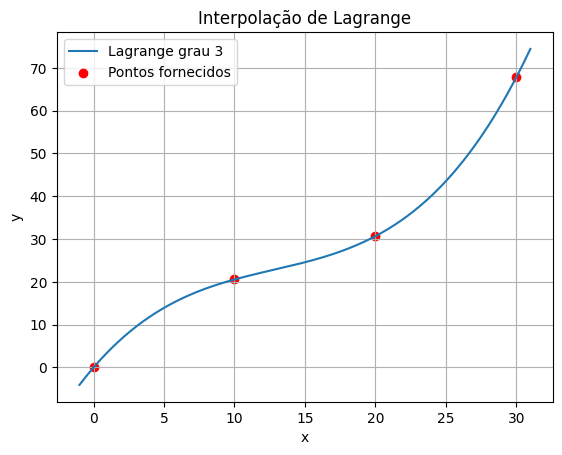

In [34]:
# === SCRIPT PRINCIPAL ===
print("Interpolação de Lagrange com seleção de grau")

modo = input("Você deseja fornecer os valores de y manualmente (1) ou usar uma função f(x) para calcular (2)? ")
n = int(input("Digite o número de pontos disponíveis: "))
x_vals = []
y_vals = []

for i in range(n):
    x = float(input(f"x{i}: "))
    x_vals.append(x)

if modo == '1':
    for i in range(n):
        y = float(input(f"y{i} correspondente a x{i} = {x_vals[i]}: "))
        y_vals.append(y)
elif modo == '2':
    f_expr = input("Digite a função f(x), exemplo: 2*exp(x) + 3: ")
    x = sp.symbols('x')
    try:
        f_sympy = sp.sympify(f_expr)
        f_numeric = sp.lambdify(x, f_sympy, 'numpy')
        y_vals = [float(f_numeric(xi)) for xi in x_vals]
    except Exception as e:
        print("Erro ao processar a função:", e)
        exit(1)
else:
    print("Modo inválido.")
    exit(1)

usar_grau_manual = input("Deseja definir o grau do polinômio? (s/n): ").lower() == 's'
if usar_grau_manual:
    grau = int(input(f"Informe o grau desejado (0 a {n-1}): "))
    x_sel, y_sel = escolher_pontos(x_vals, y_vals, grau)
else:
    grau = n - 1
    x_sel, y_sel = x_vals, y_vals

# Construção do polinômio
L, f_lagrange = construir_polinomio_lagrange(np.array(x_sel), np.array(y_sel))

print("\nPolinômio interpolador de Lagrange:")
print(sp.pretty(L, use_unicode=True))

# Loop interativo
while True:
    escolha = input("\nDeseja (1) estimar y dado x ou (2) estimar x dado y? ('sair' para encerrar): ")
    if escolha.lower() == 'sair':
        break
    elif escolha == '1':
        try:
            x_input = float(input("Digite um valor de x: "))
            y_estimado = f_lagrange(x_input)
            print(f"Para x = {x_input:.4f}, y estimado = {y_estimado:.4f}")
        except Exception as e:
            print("Erro:", e)
    elif escolha == '2':
        try:
            y_input = float(input("Digite um valor de y: "))
            x_sols = interpolar_inverso(L, y_input)
            if x_sols:
                print(f"Possíveis x para y = {y_input:.4f}:")
                for xs in x_sols:
                    print(f"x ≈ {xs:.4f}")
            else:
                print("Nenhuma solução real encontrada.")
        except Exception as e:
            print("Erro:", e)
    else:
        print("Escolha inválida.")

# Plot
x_plot = np.linspace(min(x_vals) - 1, max(x_vals) + 1, 500)
y_plot = f_lagrange(x_plot)

plt.plot(x_plot, y_plot, label=f'Lagrange grau {grau}')
plt.scatter(x_vals, y_vals, color='red', label='Pontos fornecidos')
plt.title('Interpolação de Lagrange')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()